In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np
import statsmodels.api as sm
import statsmodels 
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import fisher_exact

pd.set_option('display.max_rows', None)  # Отображение всех строк  
pd.set_option('display.max_columns', None)  # Отображение всех столбцов  

In [48]:
regions = pd.read_csv('regions.csv')
starts = pd.read_csv('starts.csv')
volunteers = pd.read_csv('volunteers.csv')

starts = starts[starts.athlete_age < 80]
starts = starts[starts.finish_time < 3600]
starts['is_male'] = starts['athlete_gender'].apply(lambda x: 1 if x == 'мужской' else 0)
starts = starts[starts['athlete_age'] > 14]
#индекс дискомфорта
starts['discomfort_index'] = starts['temp'] - (0.55 - 0.0055 * starts['humidity']) * (starts['temp'] - 14.5)

volunteer_counts = volunteers.groupby(['event_date','event_name', 'volunteer_role_name']).size().unstack(fill_value=0)  
starts = starts.merge(volunteer_counts, on=['event_date','event_name'], how='left')  
print(starts.isnull().sum())
 



record_id                                 0
athlete_id                                0
event_name                                0
event_date                                0
city                                      0
region                                    0
finish_time                               0
athlete_gender                            0
athlete_age                               0
is_newbie                                 0
temp                                      0
feels_like                                0
pressure                                  0
humidity                                  0
dew_point                                 0
clouds                                    0
wind_speed                                0
wind_deg                                  0
weather.main                              0
weather.description                       0
rain.1h                              151886
snow.1h                              158560
track_description_surface       

Я посмотрел, это происходит в набережных челнах и в каком-то городе московской области, что там на пробежках нет НИ одного волонтера. Это странно, кто же тогда считывал штрихкоды и тп? может быть потом я выкину эти пробежки, но пока просто заполню нулями что там 0 волонтеров (тк так оно и есть, nan появились из-за слияния что по event_name и event_date нет даже 1 волонтера хотя бы 1 роли)

In [49]:
# columns_to_fill = starts.columns.difference(['snow.1h', 'rain.1h'])  
# starts[columns_to_fill] = starts[columns_to_fill].fillna(0)  
# Удаляем строки, где есть NaN, кроме snow.1h и rain.1h  
print(len(starts))
starts = starts.dropna(subset=[col for col in starts.columns if col not in ['snow.1h', 'rain.1h']])  
print(len(starts))


167411
166595


In [50]:
starts.loc[:,'is_repeated'] = starts.groupby('athlete_id')['event_date'].transform(lambda x: x.count() > 1)
starts['is_newbie'] = starts['is_newbie'].astype(int)
starts['is_repeated'] = starts['is_repeated'].astype(int)

Я решил выкинуть те самые 5 регионов, в которые 5 верст зашли во 2 половине 2023 года

In [51]:
starts = starts[~starts['region'].isin(['Республика Адыгея', 'Республика Карелия', 'Липецкая область', 'Сахалинская область', 'Архангельская область'])]  

In [52]:
starts = starts[starts.event_date >= '2023-01-01'] 
starts = starts[starts.event_date <= '2023-11-01']
# чтобы щас хотя бы как то резульаты были правдивые, я выкину крайние месяцы года, тк там люди могут перестать приходить из за погоды
newbie = starts[starts['is_newbie'] == 1]
print('кол-во уникальных бегунов, которые зарегались до 2023:', len(starts[starts['is_newbie'] == 0].drop_duplicates('athlete_id'))) 
print('кол-во новичков, которые пришли во 2 раз:',len(newbie[newbie.is_repeated == 1].drop_duplicates('athlete_id')))
print('кол-во новичков, которые не пришли после 1 раза:',len(newbie[newbie.is_repeated == 0].drop_duplicates('athlete_id')))

кол-во уникальных бегунов, которые зарегались до 2023: 8473
кол-во новичков, которые пришли во 2 раз: 8847
кол-во новичков, которые не пришли после 1 раза: 8152


In [53]:
first_runs = newbie.sort_values(by='event_date').drop_duplicates('athlete_id')
didnt_come = newbie[newbie.is_repeated == 0]

come = first_runs[first_runs.is_repeated == 1]

print(len(come), len(didnt_come))
first_runs.head(2)

8847 8152


,record_id,athlete_id,event_name,event_date,city,region,finish_time,athlete_gender,athlete_age,is_newbie,temp,feels_like,pressure,humidity,dew_point,clouds,wind_speed,wind_deg,weather.main,weather.description,rain.1h,snow.1h,track_description_surface,is_male,discomfort_index,Ведущий велосипед,Завершение мероприятия,Замыкающий,Инструктаж новых участников,Координатор парковки,Координация волонтёров,Лидер для слабовидящих,Маршал,Обработка результатов,Организатор,Организация финиша,Пейсер,Подготовка мероприятия,Помощь в раздаче карточек позиций,Проведение разминки,Проверка карточек позиций,Проверка трассы,Раздача карточек позиций,Разное,Связи с общественностью,Секундомер,Сканирование штрих-кодов,Сортировка карточек,Составление отчёта,Сурдопереводчик,Фотограф,Хранение и доставка оборудования,is_repeated
109464,4816,790126907,Петергоф Александрийский,2023-01-01,Санкт-Петербург,Санкт-Петербург,2092,женский,16,1,2.71,-1.99,997,95,1.99,100,5.95,263,Clouds,overcast clouds,NaN,NaN,грунт,0,3.034225,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,4.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,2.0,1.0,0.0,0.0,0.0,3.0,0.0,0
106351,4782,790125851,Волгоград панорама,2023-01-01,Волгоград,Волгоградская область,1940,мужской,37,1,1.74,-3.68,1025,87,-0.16,75,7.00,260,Clouds,broken clouds,NaN,NaN,твердое,1,2.652340,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1


In [54]:
come_with_didnt_come = pd.concat([come, didnt_come])
come_with_didnt_come['cnt_volunteers'] = come_with_didnt_come.iloc[:, 25:52].sum(axis=1)
num_col = come_with_didnt_come.select_dtypes('number')



print(num_col.corr(method="spearman")['is_repeated'])
display(come_with_didnt_come.head(2))


record_id                           -0.140217
athlete_id                          -0.153857
finish_time                         -0.095591
athlete_age                          0.115777
is_newbie                                 NaN
temp                                -0.016868
feels_like                          -0.021360
pressure                            -0.016401
humidity                            -0.034166
dew_point                           -0.044848
clouds                              -0.022571
wind_speed                           0.040166
wind_deg                             0.031724
rain.1h                              0.188882
snow.1h                             -0.063461
is_male                              0.044996
discomfort_index                    -0.020237
Ведущий велосипед                   -0.042894
Завершение мероприятия              -0.050103
Замыкающий                          -0.115859
Инструктаж новых участников         -0.034315
Координатор парковки              

,record_id,athlete_id,event_name,event_date,city,region,finish_time,athlete_gender,athlete_age,is_newbie,temp,feels_like,pressure,humidity,dew_point,clouds,wind_speed,wind_deg,weather.main,weather.description,rain.1h,snow.1h,track_description_surface,is_male,discomfort_index,Ведущий велосипед,Завершение мероприятия,Замыкающий,Инструктаж новых участников,Координатор парковки,Координация волонтёров,Лидер для слабовидящих,Маршал,Обработка результатов,Организатор,Организация финиша,Пейсер,Подготовка мероприятия,Помощь в раздаче карточек позиций,Проведение разминки,Проверка карточек позиций,Проверка трассы,Раздача карточек позиций,Разное,Связи с общественностью,Секундомер,Сканирование штрих-кодов,Сортировка карточек,Составление отчёта,Сурдопереводчик,Фотограф,Хранение и доставка оборудования,is_repeated,cnt_volunteers
106351,4782,790125851,Волгоград панорама,2023-01-01,Волгоград,Волгоградская область,1940,мужской,37,1,1.74,-3.68,1025,87,-0.16,75,7.00,260,Clouds,broken clouds,NaN,NaN,твердое,1,2.652340,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1,12.0
42589,4816,790090276,Петергоф Александрийский,2023-01-01,Санкт-Петербург,Санкт-Петербург,1932,мужской,56,1,2.71,-1.99,997,95,1.99,100,5.95,263,Clouds,overcast clouds,NaN,NaN,грунт,1,3.034225,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,4.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,2.0,1.0,0.0,0.0,0.0,3.0,0.0,1,19.0


Откинем не стат значимые корреляции и сделаем логит модель.

In [55]:
insignificant_vars = []  

# Обходим все целочисленные столбцы  

for col in num_col.columns:      
    try:
        if col != 'is_repeated':  # пропускаем целевую переменную  
        # Рассчитываем коэффициент корреляции Спирмена и p-значение  
            corr, p_value = stats.spearmanr(num_col[col], num_col['is_repeated'])  

        
        # Если p-значение больше 0.05, то переменная не стат значимо влияет на newbie_ratio  
            if p_value > 0.05:  
                insignificant_vars.append(col)  
    except Exception:
        print(f'Nan по {col} столбцу есть')
print()
# Выводим все целочисленные переменные, которые не влияют стат значимо на newbie_ratio  
print("Неподходящие целочисленные переменные:", insignificant_vars)
print(len(insignificant_vars))
# Удаляем незначимые переменные (по корреляции) из датафрейма  
num_col_starts = num_col.drop(columns=insignificant_vars)  


Неподходящие целочисленные переменные: ['Координатор парковки', 'Лидер для слабовидящих', 'Организация финиша', 'Пейсер', 'Раздача карточек позиций', 'Составление отчёта', 'Сурдопереводчик']
7


D:\Anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


<Axes: xlabel='cnt_volunteers', ylabel='Count'>

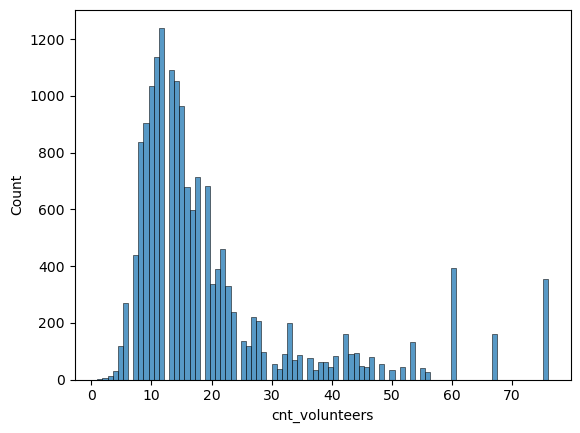

In [56]:
sns.histplot(num_col_starts.cnt_volunteers)

Семен делает статтесты для проверки значимости разницы средних выборок С опред. волонтерами и БЕЗ них

In [57]:
come_with_didnt_come.Маршал.value_counts()

Маршал
0.0     5450
1.0     3976
2.0     2330
3.0     1599
5.0      770
4.0      746
11.0     490
6.0      478
27.0     355
13.0     235
7.0      175
9.0      144
8.0      106
12.0      75
10.0      44
15.0      26
Name: count, dtype: int64

In [58]:
come_with_didnt_come['Инструктаж новых участников'].value_counts()

Инструктаж новых участников
0.0    10399
1.0     6382
2.0      145
3.0       73
Name: count, dtype: int64

In [59]:
with_marshal_and_instr = come_with_didnt_come[['Маршал', 'Инструктаж новых участников', 'is_repeated']]

In [67]:
marshal_0 = with_marshal_and_instr[with_marshal_and_instr.Маршал == 0].is_repeated
marshal_1 = with_marshal_and_instr[with_marshal_and_instr.Маршал >= 1].is_repeated
print(marshal_0.value_counts())
print(marshal_0.shape[0], marshal_1.shape[0], marshal_1.value_counts()[1]/marshal_1.shape[0], marshal_0.value_counts()[0]/marshal_0.shape[0])

is_repeated
1    3085
0    2365
Name: count, dtype: int64
5450 11549 0.49891765520824316 0.43394495412844036


In [61]:
marshal_0.value_counts()

is_repeated
1    3085
0    2365
Name: count, dtype: int64

In [62]:
marshal_1.value_counts()

is_repeated
0    5787
1    5762
Name: count, dtype: int64

Доля успехов не экстремальна, выборка достаточно большая ==> для сравнения выборок будем делать двухпропорциональный Z-тест на долях 

In [63]:
x1 = marshal_0.value_counts()[0]
n1 = marshal_0.shape[0]
x2 = marshal_1.value_counts()[1]
n2 = marshal_1.shape[0]
count = [x1, x2]
nobs = [n1, n2]
stats, pval = statsmodels.stats.proportion.proportions_ztest(count, nobs, value=0)
print('Z-value:', stats)
print('p value:', pval)

Z-value: -7.914749136934743
p value: 2.4775213345210145e-15


In [64]:
volunteers_cols = come_with_didnt_come.columns[25:52]  
results = []

for vol in volunteers_cols:
    group_vol = come_with_didnt_come[come_with_didnt_come[vol] > 0]
    group_no_vol = come_with_didnt_come[come_with_didnt_come[vol] == 0]
    
    x1 = group_vol['is_repeated'].sum()
    n1 = group_vol.shape[0]
    x2 = group_no_vol['is_repeated'].sum()
    n2 = group_no_vol.shape[0]


    if min(x1, n1 - x1, x2, n2 - x2) < 5:
        table = np.array([[x1, n1 - x1],
                          [x2, n2 - x2]])
        oddsratio, p_value = fisher_exact(table)
        test_type = 'Fisher'
    else:
        count = [x1, x2]
        nobs = [n1, n2]
        stat, p_value = proportions_ztest(count, nobs, value=0)
        test_type = 'Z-test'
    
    results.append({
        'volunteer': vol,
        'test_type': test_type,
        'p_value': p_value,
        'n1': n1,
        'n2': n2,
        'p1': x1/n1 if n1>0 else np.nan,
        'p2': x2/n2 if n2>0 else np.nan,
        'significant': 1 if p_value<0.05 else 0
    })
    z_results = pd.DataFrame(results)

In [65]:
z_results

,volunteer,test_type,p_value,n1,n2,p1,p2,significant
0,Ведущий велосипед,Z-test,2.158984e-08,302,16697,0.360927,0.523328,1
1,Завершение мероприятия,Z-test,5.603970e-12,2128,14871,0.450658,0.530428,1
2,Замыкающий,Z-test,3.658033e-02,16786,213,0.519540,0.591549,1
3,Инструктаж новых участников,Z-test,5.794594e-06,6600,10399,0.498636,0.534282,1
4,Координатор парковки,Z-test,8.251531e-02,113,16886,0.601770,0.519898,0
5,Координация волонтёров,Z-test,4.530891e-59,3488,13511,0.398222,0.551995,1
6,Лидер для слабовидящих,Z-test,6.941311e-01,316,16683,0.509494,0.520650,0
7,Маршал,Z-test,2.899775e-16,11549,5450,0.498918,0.566055,1
8,Обработка результатов,Z-test,3.820830e-04,13065,3934,0.512974,0.545247,1
9,Организатор,Z-test,3.488398e-01,16955,44,0.520260,0.590909,0
